In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_main = pd.read_csv('/Users/ziadharmanani/Desktop/BoC_BankRate/data/bank_rate_clean.csv', 
                      parse_dates=['DATE'],
                      index_col='DATE')

In [23]:
df_main.info()
df_main.index.is_monotonic_increasing
df_main['VALUE'].isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17006 entries, 1960-07-27 to 2025-11-27
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GEO            17006 non-null  object 
 1   INDICATOR      17006 non-null  object 
 2   UOM            17006 non-null  object 
 3   UOM_ID         17006 non-null  int64  
 4   SCALAR_FACTOR  17006 non-null  object 
 5   SCALAR_ID      17006 non-null  int64  
 6   VALUE          17006 non-null  float64
 7   STATUS         0 non-null      float64
 8   SYMBOL         0 non-null      float64
 9   TERMINATED     0 non-null      float64
dtypes: float64(4), int64(2), object(4)
memory usage: 1.4+ MB


np.int64(0)

In [24]:
df_main['VALUE'].describe()

count    17006.000000
mean         5.609137
std          3.876981
min          0.500000
25%          2.750000
50%          4.750000
75%          8.180000
max         21.240000
Name: VALUE, dtype: float64

In [26]:
df_main.index.to_series().diff().value_counts().head()

DATE
1 days    13591
3 days     3377
4 days       31
2 days        4
5 days        2
Name: count, dtype: int64

In [27]:
# Create a time-series stocastic process realization
bank_rate_ts = df_main.drop(columns=['GEO', 'INDICATOR', 'STATUS', 'SYMBOL', 'TERMINATED'])
unit = bank_rate_ts['UOM'].iloc[0]
scale = bank_rate_ts['SCALAR_FACTOR'].iloc[0]

bank_rate_ts = bank_rate_ts.rename(columns={'VALUE': 'bank_rate'})
bank_rate_ts = bank_rate_ts.drop(columns=['UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID'])

In [28]:
# Breaking down the years into intervals
bank_rate_binned = bank_rate_ts.copy()
bank_rate_binned['year'] = bank_rate_binned.index.year
bank_rate_binned['interval'] = pd.cut(
    bank_rate_binned.index.year,
    bins = [1959, 1989, 2007, 2019, 2025],
    labels = [
        '1960 - 1989',
        '1990 - 2007',
        '2008 - 2019',
        '2020 - 2025'
        ])

bank_rate_binned.groupby('interval')['bank_rate'].describe()

/var/folders/dv/8f4r5dp50yv_lywv_s27_ncw0000gn/T/ipykernel_8596/1005195149.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank_rate_binned.groupby('interval')['bank_rate'].describe()


,count,mean,std,min,25%,50%,75%,max
interval,,,,,,,,
1960 - 1989,7678.0,8.107807,3.592274,1.93,5.0000,8.00,9.7475,21.24
1990 - 2007,4696.0,5.310637,2.571269,2.25,3.4375,4.75,6.0000,14.05
2008 - 2019,3131.0,1.339109,0.739763,0.50,0.7500,1.25,1.5000,4.50
2020 - 2025,1501.0,2.668721,1.890407,0.50,0.5000,3.00,4.7500,5.25


In [29]:
# Shows if changes are discreet and where are large shocks
bank_rate_binned['rate_change'] = bank_rate_binned['bank_rate'].diff()
bank_rate_binned['rate_change'].value_counts().head()

rate_change
 0.00    15961
-0.25       48
 0.25       37
 0.50       33
-0.50       31
Name: count, dtype: int64

In [30]:
# Policy granularity
rate_changes = bank_rate_binned[bank_rate_binned['rate_change'] != 0].copy()
rate_changes['rate_change'].value_counts().sort_index() # Distribution of rate changes

rate_change
-1.57    1
-1.51    1
-1.49    1
-1.47    1
-1.23    1
        ..
 1.11    1
 1.22    1
 1.29    1
 1.38    1
 1.93    1
Name: count, Length: 279, dtype: int64

In [31]:
# Cuts vs hikes per year interval
rate_changes['direction'] = np.where(rate_changes['rate_change'] > 0, 'Hike', 'Cut')
rate_changes['direction'].value_counts()
rate_changes.groupby(['interval', 'direction']).size()

/var/folders/dv/8f4r5dp50yv_lywv_s27_ncw0000gn/T/ipykernel_8596/1717211087.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_changes.groupby(['interval', 'direction']).size()


interval     direction
1960 - 1989  Cut          307
             Hike         326
1990 - 2007  Cut          239
             Hike         131
2008 - 2019  Cut           11
             Hike           8
2020 - 2025  Cut           13
             Hike          10
dtype: int64

In [32]:
#TODO: Days since the last cut or hike
rate_changes['days_since_last'] = (rate_changes.index.to_series().diff().dt.days)
rate_changes['days_since_last'].describe()

count    1044.000000
mean       22.831418
std        75.973391
min         1.000000
25%         7.000000
50%         7.000000
75%         7.000000
max      1596.000000
Name: days_since_last, dtype: float64

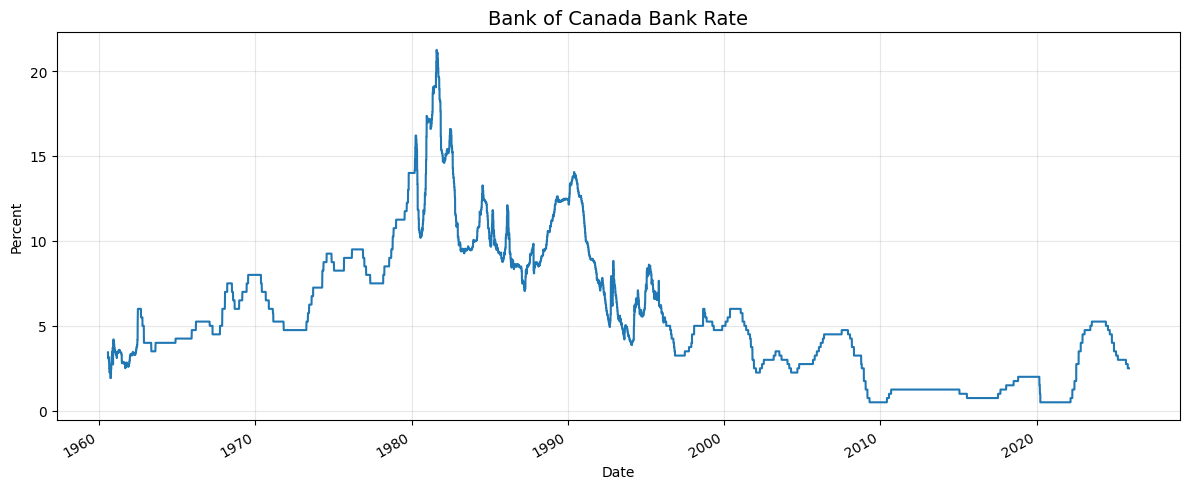

In [33]:
# Change in Bank Rate Over Time
fig, ax = plt.subplots(figsize = (12, 5))
bank_rate_ts.plot(ax = ax, legend = False)

ax.set_title('Bank of Canada Bank Rate', fontsize = 14)
ax.set_ylabel('Percent')
ax.set_xlabel('Date')
ax.grid(True, alpha=0.3)

plt.tight_layout()

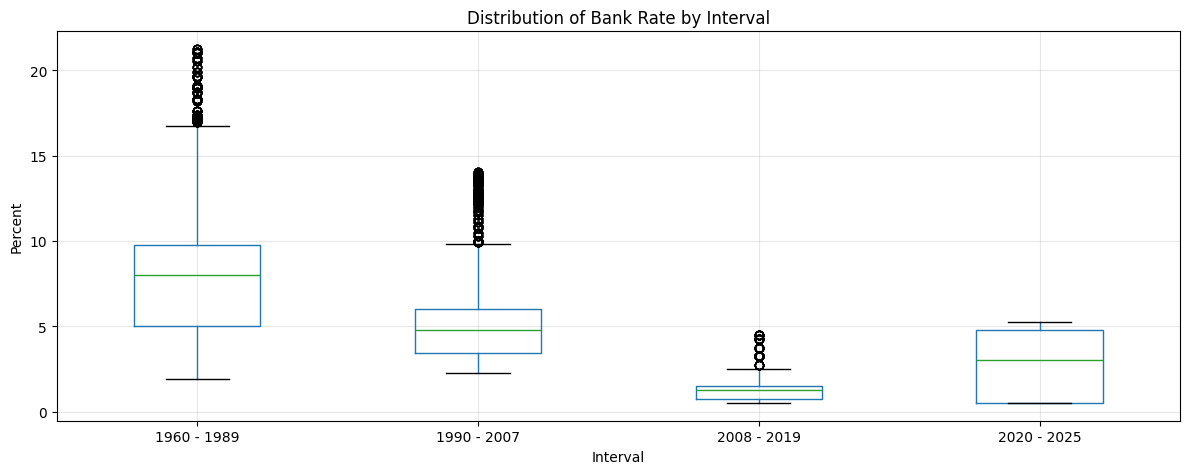

In [34]:
# Distribution of bank rates (by interval)
fig, ax = plt.subplots(figsize = (12, 5))

bank_rate_binned.boxplot(column = 'bank_rate', by = 'interval', ax = ax)

ax.set_title('Distribution of Bank Rate by Interval')
ax.set_ylabel('Percent')
ax.set_xlabel('Interval')
ax.grid(True, alpha=0.3)
plt.suptitle('')

plt.tight_layout()

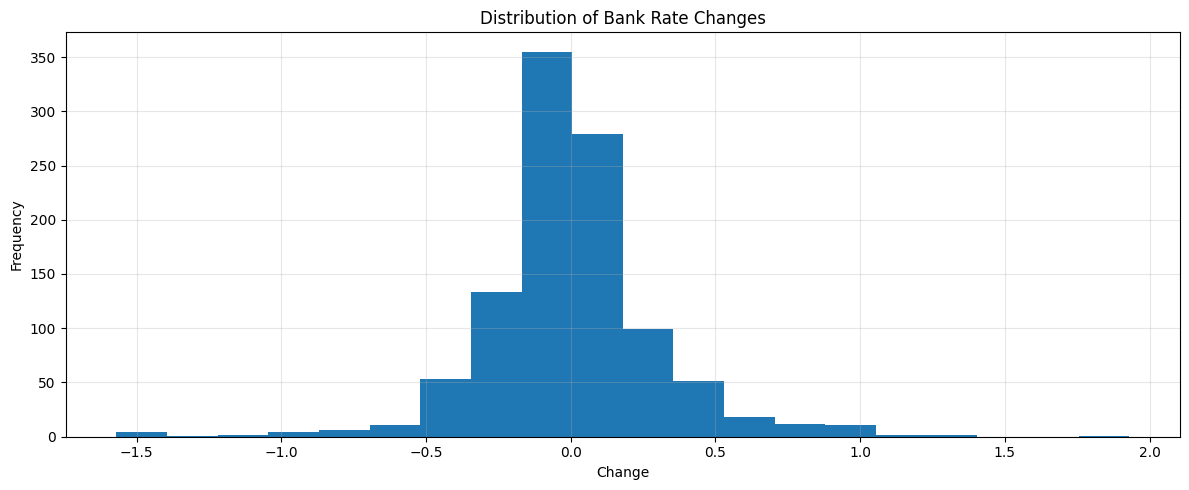

In [35]:
# Histogram of rate changes (policy granularity)
fig, ax = plt.subplots(figsize=(12, 5))

rate_changes['rate_change'].hist(bins = 20, ax = ax)

ax.set_title('Distribution of Bank Rate Changes')
ax.set_xlabel('Change')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)

plt.tight_layout()

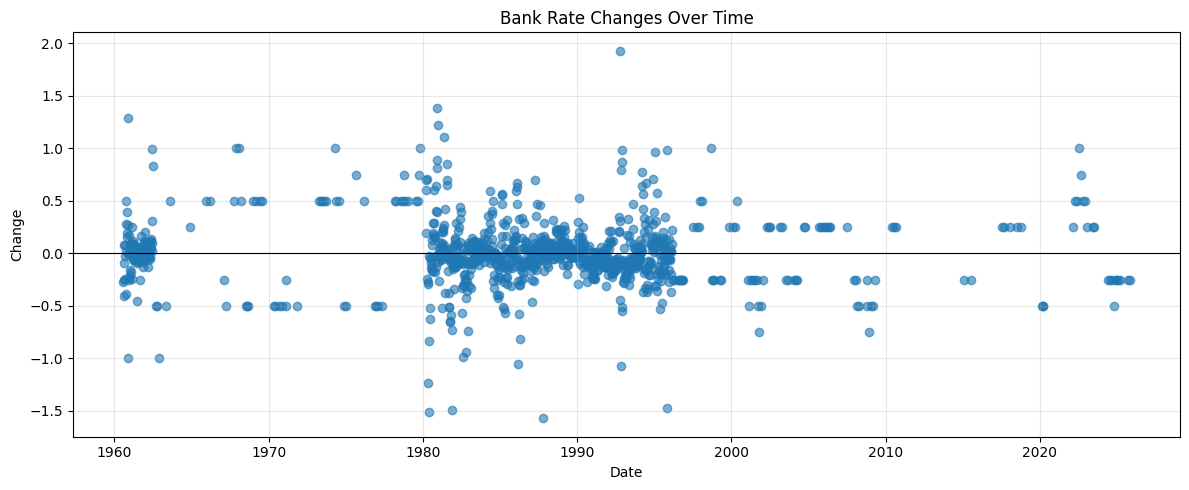

In [36]:
# Rate change size over time
fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(rate_changes.index, rate_changes['rate_change'], alpha = 0.6)

ax.axhline(0, color = 'black', linewidth = 0.8)
ax.set_title('Bank Rate Changes Over Time')
ax.set_ylabel('Change')
ax.set_xlabel('Date')
ax.grid(True, alpha = 0.3)

plt.tight_layout()